# Curate acoustic data

Notebook within the chronic ephys processing pipeline
- 1-preprocess_acoustics
- **2-curate_acoustics**
- 3-sort_spikes
- 4-curate_spikes

Use the environment **songproc** to run this notebook

In [1]:
%matplotlib widget
import os
import numpy as np
import pandas as pd
import pickle
import IPython.display as ipd
import sys
sys.path.append('/mnt/cube/lo/envs/ceciestunepipe')
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.pipeline import searchbout as sb
from ceciestunepipe.mods import curate_bouts as cb

import logging
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.WARNING) # set to logging.INFO if you'd like to see the full readout

## Set parameters

In [2]:
# session parameters
sess_par = {
    'bird':'z_p5y10_23', # bird ID
    'sess':'2024-05-16', # session date
    'ephys_software':'sglx', # recording software, sglx or oe
    'stim_sess':False, # if song stimulus was played during the session, ignore detected bouts
    'trim_bouts':True, # manually trim bouts after curation
    'sort':'sort_0', # sort index
}

# set type of ALSA bout dataframe to load, depending on how far it's been previously processed
bout_df_type = 'checked' # options are 'auto' (not checked), 'checked' (checked not trimmed), and 'curated' (checked and trimmed)

## Load bouts captured through ADC channels in neural acquisition

In [3]:
# load bouts
hparams, bout_df = sb.load_bouts(sess_par['bird'],sess_par['sess'],'',
                                derived_folder='bouts_{}'.format(sess_par['ephys_software']),
                                bout_file_key='bout_sync_file')

# get sample rate and ensure same for all bouts
fs, bout_dicts_all = cb.epoch_bout_dict_sample_rate_check(bout_df, sess_par)

# if stim session, remove stim that overlap with bouts
if sess_par['stim_sess']:
    bout_df_updated = cb.remove_stim_bouts(bout_df, sess_par)
    print('All bouts:',len(bout_df), ' | Post stim removal:',len(bout_df_updated)) 
else:
    bout_df_updated = bout_df.copy()
    print('Bouts:',len(bout_df))

Bouts: 420


## Load bouts captured through alsa

In [ ]:
# load bouts
bout_df_alsa = sb.load_bouts_alsa(sess_par['bird'], sess_par['sess'], bout_df_type)

# get sample rate and ensure same for all bouts
fs_alsa = cb.bout_fs_check(bout_df_alsa)

### not doing anything with this yet, but could load bouts for the whole day and pair with SGLX session ###

## Curate bouts
Review results of automatic bout detection algorithm to remove any false bout detections

In [4]:
bout_df_updated = bout_df_updated.assign(bout_check=True, confusing=False, is_call=False)

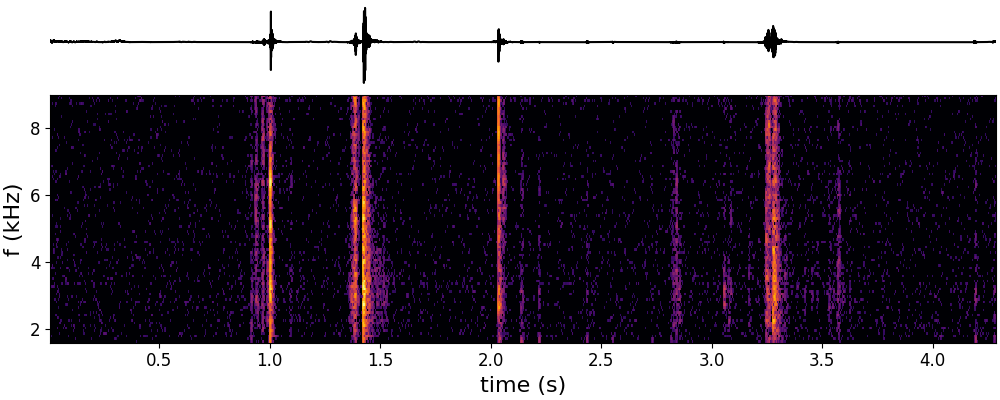

In [5]:
viz_bout = cb.VizBout(bout_df_updated, fs)

#### Option to listen to a bout

In [7]:
bout_idx = 405
ipd.Audio(bout_df_updated.iloc[bout_idx]['waveform'],rate=fs)

In [6]:
# generate bout summaries
print(f"Out of {len(bout_df_updated)} potential bouts:")
print(f"• {len(bout_df_updated[(bout_df_updated['bout_check'] == True) & (bout_df_updated['is_call'] == False)])} bouts")
print(f"• {bout_df_updated['is_call'].sum()} calls")
print(f"• {len(bout_df_updated) - bout_df_updated['bout_check'].sum()} noise")

Out of 420 potential bouts:
• 0 bouts
• 1 calls
• 419 noise


## Trim bouts:
Now that you have only the true bouts, trim the start and end points to align precise with bout onset and offset. This will improve the performance of syllable segmentation and clustering in later steps.

In [14]:
if sess_par['trim_bouts']:
    filtered_bout_df = viz_bout.bouts_pd[(viz_bout.bouts_pd['bout_check'] == True) & 
                                         (viz_bout.bouts_pd['is_call'] == False)]
    if len(filtered_bout_df)>0:
        trim_bouts = cb.TrimBout(filtered_bout_df, fs)
    else:
        print('No bouts to trim...')
else:
    print('Skipping bout trimming..')

No bouts to trim...


In [10]:
bout_idx = 0
ipd.Audio(filtered_bout_df.iloc[bout_idx]['waveform'],rate=fs)

In [12]:
# generate final bout df
if sess_par['trim_bouts']:
    if len(filtered_bout_df)>0:
        # pull out trim values
        start_s = trim_bouts.crop_min; end_s = trim_bouts.crop_max
        bout_df_final = cb.update_trimmed_bouts(filtered_bout_df, start_s, end_s, fs, fs_ap=30000)
    else:
        bout_df_final = filtered_bout_df
else:
    bout_df_final = viz_bout.bouts_pd.copy()

## Save curated acoustics

In [13]:
# save overall curated bout df
sb.save_auto_bouts(bout_df_final,sess_par,hparams,software=sess_par['ephys_software'],bout_file_key='bout_curated_file')

# loop through epochs - save curated data frames and dictionaries for each
for i,this_epoch in enumerate(np.unique(bout_df_final.epoch)):
    this_epoch_bout_df_final = bout_df_final.copy()
    epoch_struct = et.sgl_struct(sess_par,this_epoch,ephys_software=sess_par['ephys_software'])
    
    # get epoch bouts
    drop_condition = ~this_epoch_bout_df_final['file'].str.contains(this_epoch)
    this_epoch_bout_df_final.drop(this_epoch_bout_df_final[drop_condition].index, inplace=True)
    this_epoch_bout_df_final.reset_index(drop=True, inplace=True)
    
    # get bout dictionary
    this_bout_dict = bout_dicts_all[i]
    
    # update bout dictionary if necessary
    if sess_par['trim_bouts']:
        trim_keys = list(this_epoch_bout_df_final.keys()[this_epoch_bout_df_final.keys().str.contains('trim')])
        for this_key in trim_keys:
            this_bout_dict[this_key] = this_epoch_bout_df_final[this_key]
    
    # save curated bout dataframe and dictionary
    bout_dict_path = os.path.join(epoch_struct['folders']['derived'],'bout_dict_ap0_curated.pkl')
    with open(bout_dict_path, 'wb') as handle:
        pickle.dump(this_bout_dict, handle)
    bout_df_path = os.path.join(epoch_struct['folders']['derived'],'bout_pd_ap0_curated.pkl')
    this_epoch_bout_df_final.to_pickle(bout_df_path)

### Display bout times

In [ ]:
for i, r in bout_df_final.iterrows():
    
    if i > 345: # overnight stim
        break
    
    hr_start = int(r['file'][-19:-17])
    hr_end = hr_start
    mn = int(r['file'][-17:-15])
    
    mn_start = int(mn + r['start_ms']/60000)
    sec_start = int((mn + r['start_ms']/60000 - mn_start) * 60)
    while mn_start > 59:
        mn_start = mn_start-60
        hr_start = hr_start+1
    
    mn_end = int(mn + r['end_ms']/60000)
    sec_end = int((mn + r['end_ms']/60000 - mn_end) * 60)
    while mn_end > 59:
        mn_end = mn_end-60
        hr_end = hr_end+1
    
    if i < 10:
        print("index {}:   ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))
    elif i < 100:
        print("index {}:  ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))
    else:
        print("index {}: ".format(i),"{}:{:02d}:{:02d} - {}:{:02d}:{:02d}".format(hr_start, mn_start, sec_start, hr_end, mn_end, sec_end), 
              " ({:.1f}s long)".format((r['end_ms']-r['start_ms'])/1000))

## Concatenating sessions

In [36]:
with open('/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-10-27/bouts_sglx/bout_curated.pickle', 'rb') as f:
    bout_df_final = pickle.load(f)

In [10]:
bout_df_final.keys()

Index(['start_ms', 'end_ms', 'start_sample', 'end_sample', 'p_step', 'rms_p',
       'peak_p', 'bout_check', 'file', 'len_ms', 'syl_in', 'n_syl', 'peaks_p',
       'n_peaks', 'l_p_ratio', 'waveform', 'confusing', 'valid_waveform',
       'valid', 'spectrogram', 'start_ms_ap_0', 'start_sample_ap_0',
       'start_sample_naive', 'bird', 'sess', 'epoch', 'is_call'],
      dtype='object')

In [37]:
bout_df_final

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,...,valid_waveform,valid,spectrogram,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,is_call
8,187128,189488,7485120,7579520,"[12.668582973409952, 41.513719119620895, 59.29...",6.615156,134.106723,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,2360,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",187131,5643920,7389000,z_y19o20_21,2021-10-27,1033_undirected_g0,False
39,1071263,1074653,42850520,42986120,"[5.338206375397029, 3.0978681633708787, 3.9398...",6.804745,121.659218,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3390,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1071280,32168339,42187320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
52,1506162,1509293,60246480,60371720,"[11.552444728799006, 40.35527971348254, 57.706...",6.804745,153.937348,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3131,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1506186,45215500,60211720,z_y19o20_21,2021-10-27,1033_undirected_g0,False
59,1782863,1787293,71314520,71491720,"[19.734600855974794, 55.380104136620304, 88.21...",6.804745,124.455970,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,4430,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1782892,53516648,71354520,z_y19o20_21,2021-10-27,1033_undirected_g0,False
64,2002208,2007923,80088320,80316920,"[1.9347568605351688, 7.7485843417036575, 4.873...",6.804745,141.213069,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,5715,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2002240,60097092,80128320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
65,2010033,2014278,80401320,80571120,"[4.194721552563428, 34.957344918072536, 81.087...",6.804745,139.213337,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,4245,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2010065,60331845,80441320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
69,2319316,2322816,92772640,92912640,"[3.2451614405857594, 3.9892908524229553, 4.173...",4.810822,149.524894,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3500,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2319353,69610458,91998240,z_y19o20_21,2021-10-27,1033_undirected_g0,False
79,2622221,2625901,104888840,105036040,"[2.362219435555598, 3.7773330065235813, 2.1025...",4.810822,120.014404,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3680,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2622263,78697746,104812240,z_y19o20_21,2021-10-27,1033_undirected_g0,False
127,25835,33745,1033400,1349800,"[12.678209512221926, 45.38018960916082, 19.775...",6.670950,221.077734,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,7910,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",25835,805057,498600,z_y19o20_21,2021-10-27,1142_directed_g0,False
157,818867,822846,32754680,32913840,"[1.8657256449298205, 4.105385240576828, 3.9668...",6.670950,150.351373,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3979,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",818880,24596361,32651000,z_y19o20_21,2021-10-27,1142_directed_g0,False


In [14]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='sglx')
source_folder = exp_struct['folders']['derived']
wav_path_list = et.get_sgl_files_epochs(source_folder, file_filter='*wav_mic.{}'.format('npy'))

In [15]:
wav_path_list

['/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-10-27/sglx/1033_undirected_g0/wav_mic.npy',
 '/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-10-27/sglx/1142_directed_g0/wav_mic.npy']

In [16]:
file_path = wav_path_list[0]
file_path

'/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-10-27/sglx/1033_undirected_g0/wav_mic.npy'

In [17]:
npy_path = file_path.split('.')[0] + '.npy'
pkl_path = npy_path.split('.')[0] + '-npy_meta.pickle'
with open(pkl_path, 'rb') as fp:
    meta_dict = pickle.load(fp)
x = np.load(npy_path, mmap_mode='r').astype(meta_dict['dtype']).reshape(meta_dict['shape'])
s_f = meta_dict['s_f']

In [45]:
sample_offset = len(x)
sample_offset

166720513

In [46]:
ms_offset = round(len(x)/s_f*1000)
ms_offset

4168013

In [57]:
bout_df_new = bout_df_final.copy()

In [59]:
for i in [127, 157, 177, 188]:
    bout_df_new.at[i, 'start_sample'] = bout_df_final.at[i, 'start_sample'] + 166720513
    bout_df_new.at[i, 'end_sample'] = bout_df_final.at[i, 'end_sample'] + 166720513
    bout_df_new.at[i, 'start_ms'] = bout_df_final.at[i, 'start_ms'] + 4168013
    bout_df_new.at[i, 'end_ms'] = bout_df_final.at[i, 'end_ms'] + 4168013

In [62]:
bout_df_new

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,...,valid_waveform,valid,spectrogram,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,is_call
8,187128,189488,7485120,7579520,"[12.668582973409952, 41.513719119620895, 59.29...",6.615156,134.106723,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,2360,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",187131,5643920,7389000,z_y19o20_21,2021-10-27,1033_undirected_g0,False
39,1071263,1074653,42850520,42986120,"[5.338206375397029, 3.0978681633708787, 3.9398...",6.804745,121.659218,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3390,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1071280,32168339,42187320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
52,1506162,1509293,60246480,60371720,"[11.552444728799006, 40.35527971348254, 57.706...",6.804745,153.937348,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3131,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1506186,45215500,60211720,z_y19o20_21,2021-10-27,1033_undirected_g0,False
59,1782863,1787293,71314520,71491720,"[19.734600855974794, 55.380104136620304, 88.21...",6.804745,124.455970,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,4430,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1782892,53516648,71354520,z_y19o20_21,2021-10-27,1033_undirected_g0,False
64,2002208,2007923,80088320,80316920,"[1.9347568605351688, 7.7485843417036575, 4.873...",6.804745,141.213069,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,5715,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2002240,60097092,80128320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
65,2010033,2014278,80401320,80571120,"[4.194721552563428, 34.957344918072536, 81.087...",6.804745,139.213337,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,4245,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2010065,60331845,80441320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
69,2319316,2322816,92772640,92912640,"[3.2451614405857594, 3.9892908524229553, 4.173...",4.810822,149.524894,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3500,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2319353,69610458,91998240,z_y19o20_21,2021-10-27,1033_undirected_g0,False
79,2622221,2625901,104888840,105036040,"[2.362219435555598, 3.7773330065235813, 2.1025...",4.810822,120.014404,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3680,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2622263,78697746,104812240,z_y19o20_21,2021-10-27,1033_undirected_g0,False
127,4193848,4201758,167753913,168070313,"[12.678209512221926, 45.38018960916082, 19.775...",6.670950,221.077734,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,7910,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",25835,805057,498600,z_y19o20_21,2021-10-27,1142_directed_g0,False
157,4986880,4990859,199475193,199634353,"[1.8657256449298205, 4.105385240576828, 3.9668...",6.670950,150.351373,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3979,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",818880,24596361,32651000,z_y19o20_21,2021-10-27,1142_directed_g0,False


In [68]:
ap_offset = 125042153

In [70]:
ap_sr = 29999.933405327574

In [71]:
ap_offset/ap_sr*1000

4168081.019066337

In [72]:
ap_ms_offset = round(ap_offset/ap_sr*1000)
ap_ms_offset

4168081

In [69]:
bout_df_concat = bout_df_new.copy()

In [73]:
for i in [127, 157, 177, 188]:
    bout_df_concat.at[i, 'start_sample_ap_0'] = bout_df_new.at[i, 'start_sample_ap_0'] + ap_offset
    bout_df_concat.at[i, 'start_ms_ap_0'] = bout_df_new.at[i, 'start_ms_ap_0'] + ap_ms_offset

In [78]:
bout_df_concat

,start_ms,end_ms,start_sample,end_sample,p_step,rms_p,peak_p,bout_check,file,len_ms,...,valid_waveform,valid,spectrogram,start_ms_ap_0,start_sample_ap_0,start_sample_naive,bird,sess,epoch,is_call
8,187128,189488,7485120,7579520,"[12.668582973409952, 41.513719119620895, 59.29...",6.615156,134.106723,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,2360,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",187131,5643920,7389000,z_y19o20_21,2021-10-27,1033_undirected_g0,False
39,1071263,1074653,42850520,42986120,"[5.338206375397029, 3.0978681633708787, 3.9398...",6.804745,121.659218,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3390,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1071280,32168339,42187320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
52,1506162,1509293,60246480,60371720,"[11.552444728799006, 40.35527971348254, 57.706...",6.804745,153.937348,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3131,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1506186,45215500,60211720,z_y19o20_21,2021-10-27,1033_undirected_g0,False
59,1782863,1787293,71314520,71491720,"[19.734600855974794, 55.380104136620304, 88.21...",6.804745,124.455970,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,4430,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1782892,53516648,71354520,z_y19o20_21,2021-10-27,1033_undirected_g0,False
64,2002208,2007923,80088320,80316920,"[1.9347568605351688, 7.7485843417036575, 4.873...",6.804745,141.213069,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,5715,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2002240,60097092,80128320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
65,2010033,2014278,80401320,80571120,"[4.194721552563428, 34.957344918072536, 81.087...",6.804745,139.213337,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,4245,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2010065,60331845,80441320,z_y19o20_21,2021-10-27,1033_undirected_g0,False
69,2319316,2322816,92772640,92912640,"[3.2451614405857594, 3.9892908524229553, 4.173...",4.810822,149.524894,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3500,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2319353,69610458,91998240,z_y19o20_21,2021-10-27,1033_undirected_g0,False
79,2622221,2625901,104888840,105036040,"[2.362219435555598, 3.7773330065235813, 2.1025...",4.810822,120.014404,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3680,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2622263,78697746,104812240,z_y19o20_21,2021-10-27,1033_undirected_g0,False
127,4193848,4201758,167753913,168070313,"[12.678209512221926, 45.38018960916082, 19.775...",6.670950,221.077734,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,7910,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4193916,125847210,498600,z_y19o20_21,2021-10-27,1142_directed_g0,False
157,4986880,4990859,199475193,199634353,"[1.8657256449298205, 4.105385240576828, 3.9668...",6.670950,150.351373,True,/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-1...,3979,...,True,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4986961,149638514,32651000,z_y19o20_21,2021-10-27,1142_directed_g0,False


In [79]:
bout_df_concat.to_pickle('/mnt/cube/chronic_ephys/der/z_y19o20_21/2021-10-27/sglx/1033_undirected_g0-1142_directed_g0/bout_pd_ap0_curated.pkl')